In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jena-climate/jena_climate_2009_2016.csv


In [2]:
#循環丟棄(Recurrent dropout):使用丟棄法來解決循環層中過度適配的問題
#堆疊循環層(Stacking recurrent layers):增加神經網路的轉換表示能力，但將付出更高的運算成本為代價
#雙向循環層(Bidirectional recurrent layers):以不同方式向循環神經網路提供相同的訊息，進而提高準確度並減少神經網路的遺忘問題

In [6]:
#檢視耶拿天氣資料集的資料
data_dir = '../input/jena-climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',') #天氣資料項目
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [7]:
#解析資料
float_data = np.zeros((len(lines), len(header) - 1)) #不放入日期
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]] #不放入日期
    float_data[i, :] = values
print(float_data.shape)

(420551, 14)


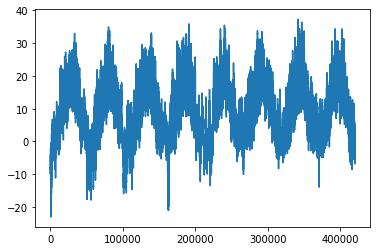

In [5]:
#溫度(攝氏)隨時間變化的曲線圖
import matplotlib.pyplot as plt

temp = float_data[:, 1] #index 1: 溫度資料
plt.plot(range(len(temp)), temp)

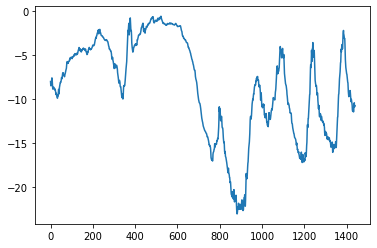

In [6]:
#觀察資料集前十天的資料(每10分鐘紀錄一次， 每天144個資料點)
plt.plot(range(1440), temp[:1440])

In [7]:
#第一圖呈現規律性的年度週期變化，表示資料集的可靠
#第二圖顯得相對混亂，看不出特定pattern

In [12]:
#標準化資料
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [8]:
#定義資料產生器，產生tuple資料集(samples 樣本數, targets 目標值)，樣本數samples對應批次量的天氣資料，目標數targets對應目標溫度陣列
#data:原始浮點數資料，並經標準化
#lookback:輸入資料應回溯多少個時間點
#delay:目標溫度應在未來多少個時間點
#min_index、max_index:資料陣列中最小與最大索引值，用以劃分時間點，來界定訓練集、驗證集和測試集
#shuffle:是否按時間順序使用樣本或打亂樣本
#batch_size = 每批次的樣本數量
#step = 產生樣本資料的時間區隔(以時間點為單位)，目前設定為6，也就是每小時取一資料點

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay
    
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples, targets

In [9]:
#建立訓練、驗證和測試資料產生器
lookback = 1440
step = 6
delay = 144
batch_size = 128

#訓練資料產生器
train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

#驗證資料產生器
val_gen = generator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=200001,
                   max_index=300000,
                   step=step,
                   batch_size=batch_size)

#測試資料產生器
test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

In [10]:
val_steps = (300000 - 200001 - lookback) // batch_size #val_gen產生器需運行多少次才可產生完整的驗證集
test_steps = (len(float_data) - 300001 - lookback) // batch_size #test_gen產生器需運行多少次才可產生完整的驗證集

In [19]:
#計算一般常識性基準方式MAE
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps): #計算所有的驗證集資料
        samples, targets = next(val_gen) #使用next()來驅動val_gen產生器，使它產生一個批次量的資料與標籤
        #print(samples.shape) #shape=(128, 240, 14) 回溯為1440個時間點，並以6個時間點為間隔取樣，共產生1440/6=240個時間點資料
        #print(targets.shape) #shape=(128,) 128筆溫度答案
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        
    print(np.mean(batch_maes))

In [20]:
evaluate_naive_method()

0.2897359729905486


In [22]:
#MAE約等於0.29，由於溫度資料已標準化為以0為中心且標準差為1，因此需透過MAE 0.29 * temperature_std 的轉換來取得攝氏溫度誤差
celsius_mae = 0.29 * std[1]
print(celsius_mae)
#此為相當大的平均絕對誤差(MAE)，利用深度學習方式來取得進步

2.5672247338393395


In [11]:
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers

In [25]:
#基本的機器學習方式
#訓練密集連接模型
model = models.Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1]))) #280, 14
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1)) #因為此為迴歸問題

2022-08-25 12:30:16.778246: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [26]:
model.compile(optimizer=optimizers.RMSprop(),
             loss='mae')

In [30]:
history = model.fit_generator(train_gen,
                   steps_per_epoch=500,
                   epochs=20,
                   validation_data=val_gen,
                   validation_steps=val_steps)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-08-25 12:35:40.400783: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
500/500 [==============================] - 10s 20ms/step - loss: 1.0773 - val_loss: 0.5916
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3526 - val_loss: 0.3541
Epoch 3/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2815 - val_loss: 0.2984
Epoch 4/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2625 - val_loss: 0.3385
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2491 - val_loss: 0.3058
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2421 - val_loss: 0.3475
Epoch 7/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2361 - val_loss: 0.3336
Epoch 8/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2288 - val_loss: 0.3486
Epoch 9/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2252 - val_loss: 0.3271
Epoch 10/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2207

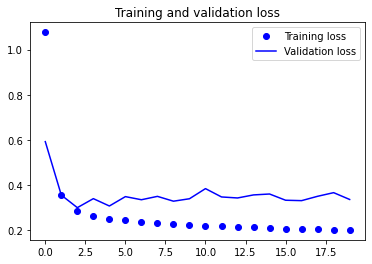

In [31]:
#繪製結果
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
#大部分驗證損失都比非機器學習的基準方法結果0.29還差，表示此模型效果不佳，因為展平時刪除了時間概念

In [33]:
#GRU(gated recurrent unit 閘控循環單元)與LSTM原理相同，但經些許簡化，使執行成本較低，缺點是模型的表示能力可能沒有LSTM好
#備註: 計算成本與表示能力間的取捨在機器學習中隨處可見

In [34]:
#GRU模型的訓練與驗證
model = models.Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [37]:
model.compile(optimizer=optimizers.RMSprop(),
             loss='mae')

In [38]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 141s 278ms/step - loss: 0.2990 - val_loss: 0.2714
Epoch 2/20
500/500 [==============================] - 137s 275ms/step - loss: 0.2855 - val_loss: 0.2677
Epoch 3/20
500/500 [==============================] - 140s 280ms/step - loss: 0.2802 - val_loss: 0.2682
Epoch 4/20
500/500 [==============================] - 140s 280ms/step - loss: 0.2739 - val_loss: 0.2680
Epoch 5/20
500/500 [==============================] - 145s 291ms/step - loss: 0.2703 - val_loss: 0.2643
Epoch 6/20
500/500 [==============================] - 140s 281ms/step - loss: 0.2646 - val_loss: 0.2640
Epoch 7/20
500/500 [==============================] - 140s 280ms/step - loss: 0.2602 - val_loss: 0.2643
Epoch 8/20
500/500 [==============================] - 140s 280ms/step - loss: 0.2555 - val_loss: 0.2670
Epoch 9/20
500/500 [==============================] - 137s 275ms/step - loss: 0.2496 - val_loss: 0.2705
Epoch 10/20
500/500 [==============================] - 134s 269m

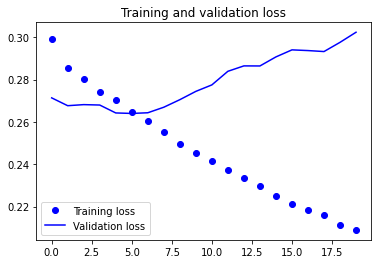

In [39]:
#繪製結果
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
#新的驗證損失MAE約為0.265(過度配適前)轉換成非標準化後的平均絕對誤差為2.35，較初始誤差2.57好，仍能改進

In [10]:
#循環丟棄法: 應在每個步驟(時間點)中都使用相同的丟棄遮罩(相同的剔除單元pattern)，而不是隨時間點增加而隨機變化的丟棄遮罩
#訓練和驗證使用丟棄法常規化的GRU模型
model = models.Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

2022-08-26 03:12:52.400040: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
model.compile(optimizer=optimizers.RMSprop(),
             loss='mae')

In [12]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-08-26 03:12:55.455495: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
500/500 [==============================] - 366s 727ms/step - loss: 0.3253 - val_loss: 0.2823
Epoch 2/40
500/500 [==============================] - 358s 716ms/step - loss: 0.3072 - val_loss: 0.2790
Epoch 3/40
500/500 [==============================] - 354s 709ms/step - loss: 0.3017 - val_loss: 0.2774
Epoch 4/40
500/500 [==============================] - 354s 708ms/step - loss: 0.2960 - val_loss: 0.2778
Epoch 5/40
500/500 [==============================] - 353s 707ms/step - loss: 0.2909 - val_loss: 0.2790
Epoch 6/40
500/500 [==============================] - 351s 703ms/step - loss: 0.2858 - val_loss: 0.2801
Epoch 7/40
500/500 [==============================] - 352s 705ms/step - loss: 0.2827 - val_loss: 0.2717
Epoch 8/40
500/500 [==============================] - 356s 712ms/step - loss: 0.2783 - val_loss: 0.2726
Epoch 9/40
500/500 [==============================] - 356s 713ms/step - loss: 0.2750 - val_loss: 0.2736
Epoch 10/40
500/500 [==============================] - 354s 708m

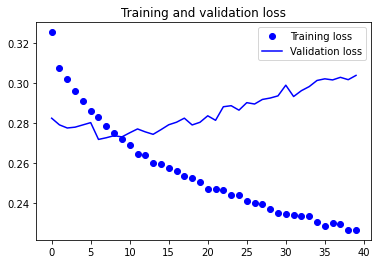

In [13]:
#繪製結果
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
#堆疊循環層
#雖不再過度配適，但遇到了性能瓶頸，我們應考慮增加神經網路容量，可以增加層的單元數或增加更多層
#要在Keras中將循環層堆疊，所有中間層應輸出完整的輸出序列資料(3D張量)，而不是在最後一個時間點輸出

In [13]:
model = models.Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

2022-08-26 15:37:16.775255: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
model.compile(optimizer=optimizers.RMSprop(),
             loss='mae')

In [15]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-08-26 15:37:19.874684: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
500/500 [==============================] - 781s 2s/step - loss: 0.3260 - val_loss: 0.2790
Epoch 2/40
500/500 [==============================] - 774s 2s/step - loss: 0.3061 - val_loss: 0.2783
Epoch 3/40
500/500 [==============================] - 774s 2s/step - loss: 0.2983 - val_loss: 0.2955
Epoch 4/40
500/500 [==============================] - 774s 2s/step - loss: 0.2912 - val_loss: 0.2674
Epoch 5/40
500/500 [==============================] - 775s 2s/step - loss: 0.2864 - val_loss: 0.2746
Epoch 6/40
500/500 [==============================] - 771s 2s/step - loss: 0.2803 - val_loss: 0.2772
Epoch 7/40
500/500 [==============================] - 773s 2s/step - loss: 0.2738 - val_loss: 0.2836
Epoch 8/40
500/500 [==============================] - 763s 2s/step - loss: 0.2687 - val_loss: 0.2825
Epoch 9/40
500/500 [==============================] - 765s 2s/step - loss: 0.2649 - val_loss: 0.2827
Epoch 10/40
500/500 [==============================] - 766s 2s/step - loss: 0.2579 - val_lo

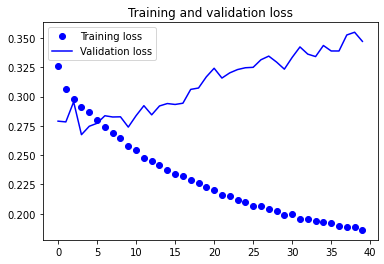

In [16]:
#繪製結果
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
#1.因為沒有太嚴重的過度配適，可以持續增加層的大小以尋求損失的改進，但這會使計算成本上升
#2.增加層並不是重要因素，因此可以看到增加神經網路的容量，並沒有得到太大的回報

In [18]:
#雙向RNN(bidirectional RNN)
#在自然語言處理方面較一般RNN好
#使用兩個一般RNN(ex:LSTM、GRU)，每個層在不同方向上處理輸入序列資料(按時間順序和反時間順序)，然後合併各自的結果
#雙向RNN透過雙向處理序列資料，可以取得單向RNN可能忽略的pattern
#字詞的順序在理解語言方面很重要，但使用的順序並不重要

In [19]:
#訓練雙向GRU進行溫度預測
model = models.Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 64)                9216      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 9,281
Trainable params: 9,281
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer=optimizers.RMSprop(),
             loss='mae')

In [22]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 278s 549ms/step - loss: 0.2995 - val_loss: 0.2715
Epoch 2/40
500/500 [==============================] - 272s 545ms/step - loss: 0.2733 - val_loss: 0.2724
Epoch 3/40
500/500 [==============================] - 272s 545ms/step - loss: 0.2675 - val_loss: 0.2743
Epoch 4/40
500/500 [==============================] - 274s 548ms/step - loss: 0.2602 - val_loss: 0.2740
Epoch 5/40
500/500 [==============================] - 273s 545ms/step - loss: 0.2543 - val_loss: 0.2709
Epoch 6/40
500/500 [==============================] - 273s 546ms/step - loss: 0.2498 - val_loss: 0.2717
Epoch 7/40
500/500 [==============================] - 273s 547ms/step - loss: 0.2423 - val_loss: 0.2737
Epoch 8/40
500/500 [==============================] - 272s 545ms/step - loss: 0.2373 - val_loss: 0.2723
Epoch 9/40
500/500 [==============================] - 273s 546ms/step - loss: 0.2318 - val_loss: 0.2842
Epoch 10/40
500/500 [==============================] - 273s 546m

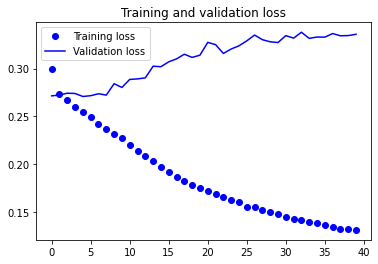

In [23]:
#繪製結果
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()